In [2]:
import os
import json
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc['reso']='xx-hi'
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/scripts/pod/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
FILEDIR    = CONFIGS['paths']['filedir']      
MODELDIR   = CONFIGS['paths']['modeldir']    
RESULTSDIR = CONFIGS['paths']['resultsdir']  
RUNS       = CONFIGS['runs']
SPLIT      = 'valid'
PRTHRESH   = 0.01
LANDTHRESH = 0.5
landfrac   = xr.open_dataarray('/global/cfs/cdirs/m4334/sferrett/monsoon-discovery/data/interim/lf.nc')

In [4]:
truepr = xr.open_dataset(os.path.join(FILEDIR,f'{SPLIT}.h5'),engine='h5netcdf')['pr'].load()

results = {}
for run in RUNS:
    runname     = run['run_name']
    description = run['description']
    predpath    = os.path.join(RESULTSDIR,f'pod_{runname}_{SPLIT}_pr.nc')
    with xr.open_dataset(predpath,engine='h5netcdf') as ds:
        predpr = ds['pr'].load()
    ytrue,ypred= xr.align(truepr,predpr,join='inner')
    results[runname] = dict(description=description,ytrue=ytrue,ypred=ypred)

In [5]:
def get_r2(ytrue,ypred,dims=None,landfrac=None,landthresh=LANDTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    if landfrac is not None:
        r2values = []
        for mask in [landfrac>=landthresh,landfrac<landthresh]:
            ssres = ((ytrue.where(mask)-ypred.where(mask))**2).sum(dim=dims,skipna=True)
            sstot = ((ytrue.where(mask)-ytrue.where(mask).mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
            r2values.append(1-ssres/sstot)
        return tuple(r2values)
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot
    
def get_confusion_matrix(ytrue,ypred,dims=None,prthresh=PRTHRESH):
    dims = list(ytrue.dims) if dims is None else dims
    ytrueabove = ytrue>prthresh
    ypredabove = ypred>prthresh
    tp = (ypredabove&ytrueabove).sum(dim=dims,skipna=True)
    tn = (~ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
    fp = (ypredabove&~ytrueabove).sum(dim=dims,skipna=True)
    fn = (~ypredabove&ytrueabove).sum(dim=dims,skipna=True)
    if dims==list(ytrue.dims) and 'member' not in ypred.dims:
        return int(tp),int(fp),int(fn),int(tn)
    return tp,fp,fn,tn

In [6]:
def plot_ramp_fits(runs=RUNS,modeldir=MODELDIR):
    fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=3,refheight=2,share=True)
    axs.format(suptitle='Ramp Fits for Singular vs. Separate Land/Ocean Fits',
               xlabel='$\mathit{B_L}$ (ms$^2$)',xlim=(-0.2,0.1),ylabel='Precipitation Rate (mm/hr)')
    for i,run in enumerate(runs):
        runname,mode,description = run['run_name'],run['mode'],run['description']
        data  = np.load(f'{modeldir}/pod_{runname}.npz')
        xbins = data['bincenters']
        if mode=='pooled':
            ymeans,fitrange = data['ymeanpooled'],data['fitrangepooled']
            alpha,blcrit    = data['alphapooled'],data['blcritpooled']
            axs[i].scatter(xbins[~fitrange],ymeans[~fitrange],color='gray',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrange],ymeans[fitrange],color='gray',marker='.',alpha=0.7)
            axs[i].plot(xbins,alpha*np.maximum(0,xbins-blcrit),color='dark gray',linewidth=2,label=f'Ramp Fit ($\\alpha$ = {alpha:.1f})')
            axs[i].axvline(blcrit,color='gray',alpha=0.5,linestyle='--',label=fr'$\mathit{{B_c}}$ = {blcrit:.3f}')
        elif mode == 'regional':
            ymeansland,fitrangeland   = data['ymeanland'],data['fitrangeland']
            alphaland,blcritland      = data['alphaland'],data['blcritland']
            ymeansocean,fitrangeocean = data['ymeanocean'],data['fitrangeocean']
            alphaocean,blcritocean    = data['alphaocean'],data['blcritocean']
            axs[i].scatter(xbins[~fitrangeland],ymeansland[~fitrangeland],color='jungle green',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrangeland],ymeansland[fitrangeland],color='jungle green',marker='.',alpha=0.7)
            axs[i].plot(xbins,alphaland*np.maximum(0,xbins-blcritland),color='spruce',linewidth=2,label=f'Land Ramp Fit ($\\alpha$ = {alphaland:.1f})')
            axs[i].axvline(blcritland,color='jungle green',alpha=0.5,linestyle='--',label=fr'Land $\mathit{{B_c}}$ = {blcritland:.3f}')
            axs[i].scatter(xbins[~fitrangeocean],ymeansocean[~fitrangeocean],color='blue3',marker='.',alpha=0.1)
            axs[i].scatter(xbins[fitrangeocean],ymeansocean[fitrangeocean],color='blue3',marker='.',alpha=0.7)
            axs[i].plot(xbins,alphaocean*np.maximum(0,xbins-blcritocean),color='blue9',linewidth=2,label=f'Ocean Ramp Fit ($\\alpha$ = {alphaocean:.1f})')
            axs[i].axvline(blcritocean,color='blue3',alpha=0.5,linestyle='--',label=fr'Ocean $\mathit{{B_c}}$ = {blcritocean:.3f}')
    axs.legend(loc='ul',ncols=1)
    pplt.show()

def plot_density_panels(results,nrows,ncols,globalmin=0,globalmax=70):
    binedges = np.linspace(globalmin,globalmax,71)
    fig,axs  = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
    axs.format(suptitle='2D Distributions (Validation Set)',xlabel='Observed Precipitation (mm/hr)',ylabel='Predicted Precipitation (mm/hr)')
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=None)
        if 'member' in ypred.dims:
            r2mean,r2std,ypredplot = r2.mean('member'),r2.std('member'),ypred.mean('member')
        else:
            r2mean,r2std,ypredplot = r2,None,ypred
        ytrueflat = ytrue.values.ravel()
        ypredflat = ypredplot.values.ravel()
        finite    = np.isfinite(ytrueflat)&np.isfinite(ypredflat)
        hist,_,_ = np.histogram2d(ytrueflat[finite],ypredflat[finite],bins=[binedges,binedges])
        hist = np.ma.masked_where(hist==0,hist)
        im   = ax.pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',vmin=1,vmax=1500,levels=100,extend='max')
        ax.plot([globalmin,globalmax],[globalmin,globalmax],color='k',linewidth=1,linestyle='--')
        text = f'R$^2$ = {r2mean:.3f} ± {r2std:.3f}' if r2std is not None else f'R$^2$ = {r2mean:.3f}'
        ax.text(0.02,0.98,text,transform=ax.transAxes,va='top',ha='left')
        ax.format(title=description,xlim=(globalmin,globalmax),xticks=10,ylim=(globalmin, globalmax),yticks=10)
    fig.colorbar(im,loc='r',label='Counts',ticks=200)
    pplt.show()

def plot_confusion_matrix(results,nrows,ncols,prthresh=PRTHRESH):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)
    axs.format(suptitle=f'Confusion Matrix (Threshold = {prthresh} mm/hr)')
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        if 'member' in ypred.dims:
            tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=list(ytrue.dims),prthresh=prthresh)
            total = tp+fp+fn+tn
            tnpct,fppct,fnpct,tppct = [100.0*x/total for x in (tn,fp,fn,tp)]
            matrixmean = np.array([[tnpct.mean('member'),fppct.mean('member')],[fnpct.mean('member'),tppct.mean('member')]],dtype=float)
            matrixstd  = np.array([[tnpct.std('member'),fppct.std('member')],[fnpct.std('member'),tppct.std('member')]],dtype=float)
        else:
            tp,fp,fn,tn = get_confusion_matrix(ytrue,ypred,dims=None,prthresh=prthresh)
            total = tp+fp+fn+tn
            matrixmean = 100.0*np.array([[tn,fp],[fn,tp]],dtype=float)/total
            matrixstd  = np.zeros_like(matrixmean)
        im = ax.pcolormesh([0,1,2],[0,1,2],matrixmean,cmap='Blues',vmin=0,vmax=100,levels=111)
        labels = [('TN',0,0,0.5,0.5),('FP',0,1,1.5,0.5),('FN',1,0,0.5,1.5),('TP',1,1,1.5,1.5)]
        for label,i,j,x,y in labels:
            meanij,stdij = matrixmean[i,j],matrixstd[i,j]
            text = f'{label}\n{meanij:.1f} ± {stdij:.1f}%' if np.nanmax(matrixstd)>0 else f'{label}\n{meanij:.1f}%'
            ax.text(x,y,text,ha='center',va='center')
        ax.format(title=description,xlim=(0,2),xticks=[0.5,1.5],xticklabels=['Predicted Dry','Predicted Wet'],xminorticks='none',
                  ylim=(0,2),yticks=[0.5,1.5],yticklabels=['Observed\nDry','Observed\nWet'],yminorticks='none')
    fig.colorbar(im,loc='r',ticks=10,label='Percent of Samples')
    pplt.show()

def plot_r2_maps(results,nrows,ncols,landfrac,latlim=(5,25),lonlim=(60,90)):
    fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=3,proj='cyl',share=False)
    axs.format(suptitle='Time-Mean Spatial Distribution of R$^2$',coast=True,latlim=latlim,lonlim=lonlim)
    for ax,(runname,result) in zip(axs,results.items()):
        description = result['description']
        ytrue,ypred = result['ytrue'],result['ypred']
        r2 = get_r2(ytrue,ypred,dims=['time'])
        if 'member' in ypred.dims:
            r2mean,r2std   = r2.mean('member'),r2.std('member')
            r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
            r2landmean,r2landstd   = r2land.mean('member'),r2land.std('member')
            r2oceanmean,r2oceanstd = r2ocean.mean('member'),r2ocean.std('member')
        else:
            r2mean,r2std   = r2,None
            r2land,r2ocean = get_r2(ytrue,ypred,dims=['time','lat','lon'],landfrac=landfrac)
            r2landmean,r2landstd   = r2land,None
            r2oceanmean,r2oceanstd = r2ocean,None
        im = ax.pcolormesh(r2mean.lon,r2mean.lat,r2mean,cmap='ColdHot',cmap_kw={'left':0.5},vmin=0,vmax=0.4,levels=9,extend='both')
        if r2std is not None:
            text = (f'Land R$^2$ = {r2landmean:.3f} ± {r2landstd:.3f}\nOcean R$^2$ = {r2oceanmean:.3f} ± {r2oceanstd:.3f}')
        else:
            text = (f'Land R$^2$ = {r2landmean:.3f}\nOcean R$^2$ = {r2oceanmean:.3f}')
        ax.text(0.05,0.95,text,transform=ax.transAxes,ha='left',va='top',bbox=dict(boxstyle='round',facecolor='white',alpha=0.8,edgecolor='k'))
        ax.format(title=description)
    fig.colorbar(im,loc='b',label='R$^2$',ticks=0.1)
    pplt.show()

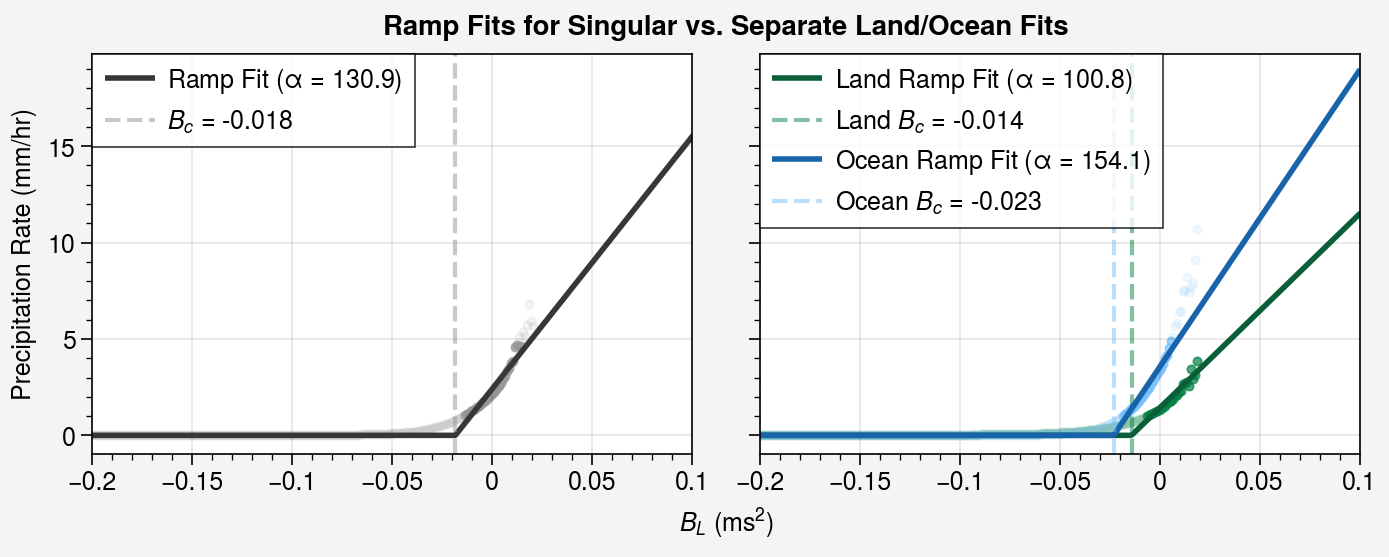

In [7]:
plot_ramp_fits()

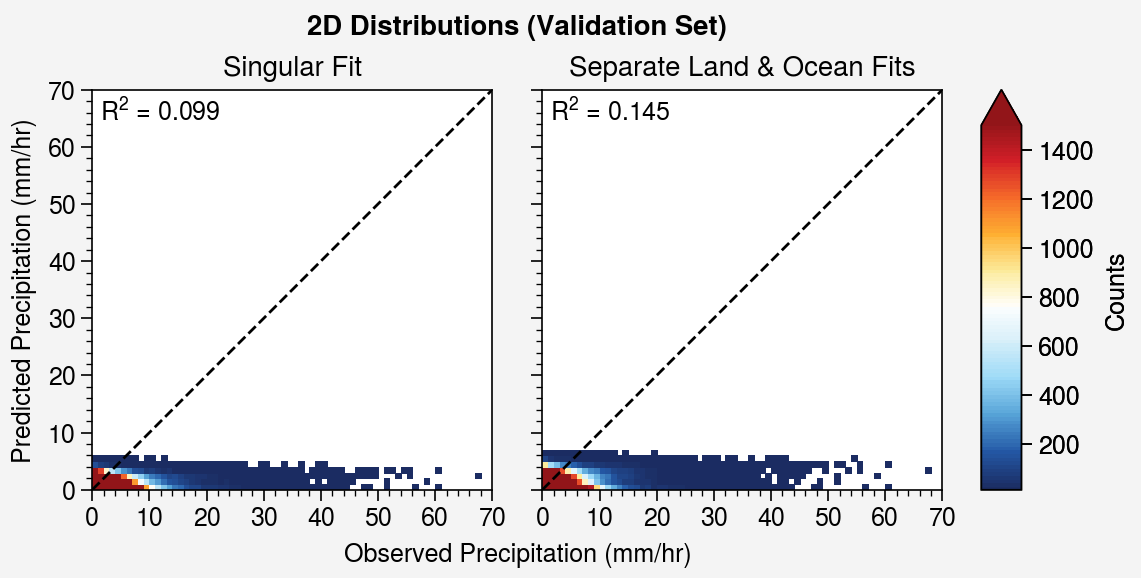

In [8]:
plot_density_panels(results,nrows=1,ncols=2)

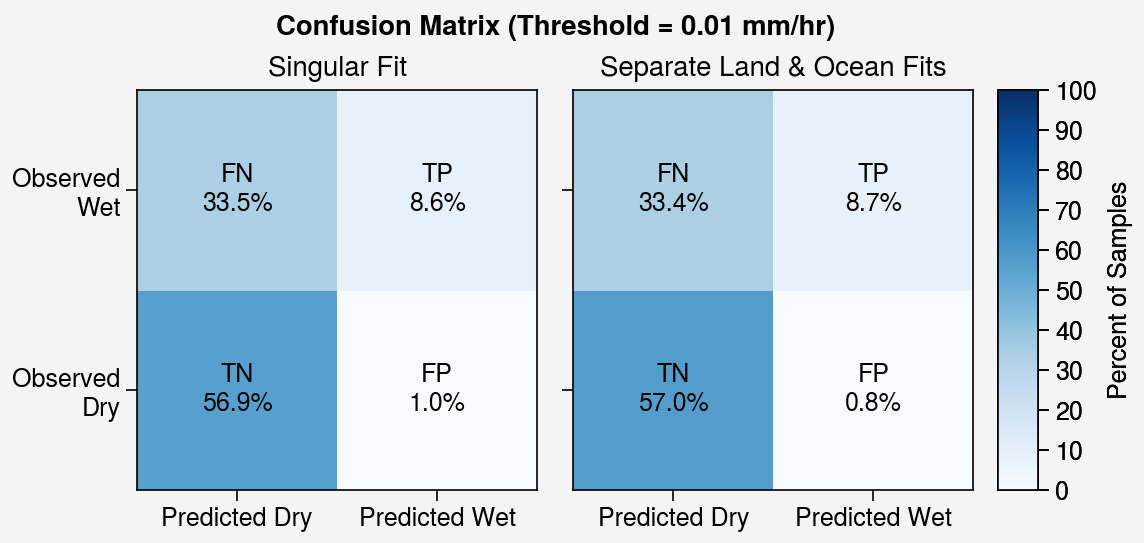

In [9]:
plot_confusion_matrix(results,nrows=1,ncols=2)

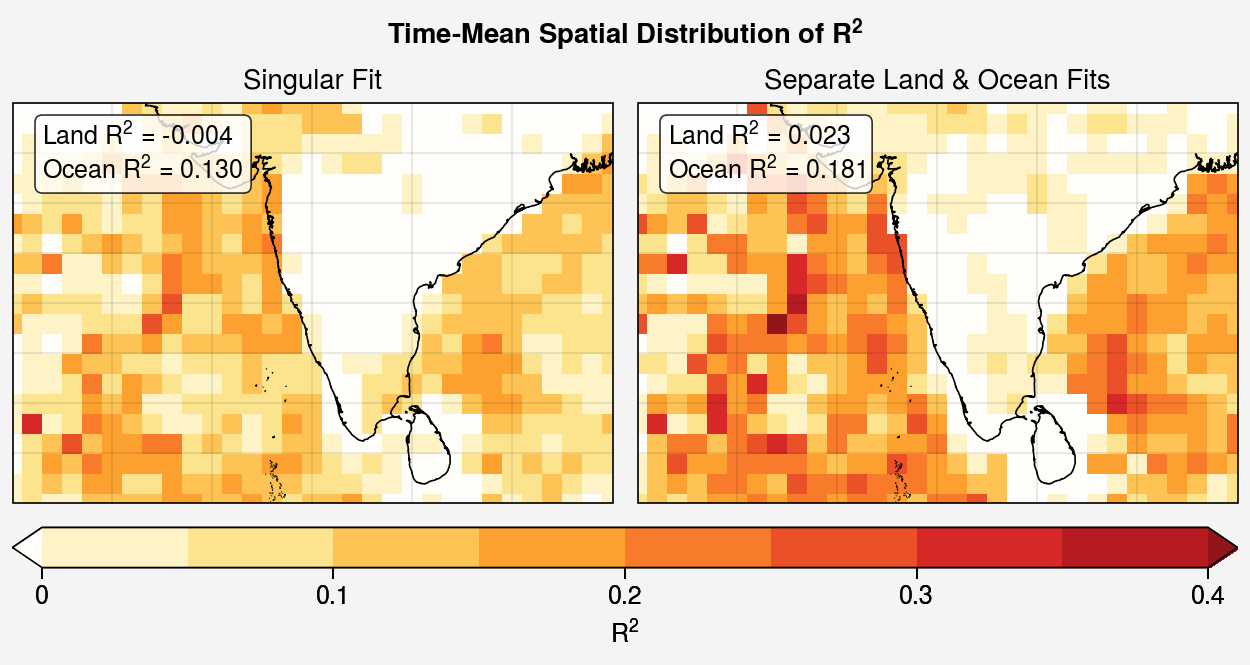

In [10]:
plot_r2_maps(results,nrows=1,ncols=2,landfrac=landfrac)